In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
import random
import os

seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda



**Here, I load the electron and photon datasets from their respective HDF5 files. I'm printing the number of samples in each dataset and then combine them into one dataset. This cell also cleans up unused variables to free memory.**


In [2]:
electron_file = "/kaggle/input/commontask-gsoc25/SingleElectronPt50_IMGCROPS_n249k_RHv1.hdf5"
photon_file   = "/kaggle/input/commontask-gsoc25/SinglePhotonPt50_IMGCROPS_n249k_RHv1.hdf5"

with h5py.File(electron_file, "r") as f:
    electron_imgs = np.array(f["X"])
    electron_labels = np.array(f["y"], dtype=np.int64)

with h5py.File(photon_file, "r") as f:
    photon_imgs = np.array(f["X"])
    photon_labels = np.array(f["y"], dtype=np.int64)

print("Number of electron samples:", len(electron_labels))
print("Number of photon samples:", len(photon_labels))
img_arrs = np.vstack((photon_imgs, electron_imgs))
labels = np.hstack((photon_labels, electron_labels)).astype(np.int64)

# Clean up memory
del electron_imgs, electron_labels, photon_imgs, photon_labels

print("Combined images shape:", img_arrs.shape)
print("Combined labels shape:", labels.shape)


Number of electron samples: 249000
Number of photon samples: 249000
Combined images shape: (498000, 32, 32, 2)
Combined labels shape: (498000,)


**This cell visualizes a few random samples from the combined dataset. For each selected image, we display both channels (hit energy and time) using different color maps, and add a title indicating the particle type (electron or photon)**

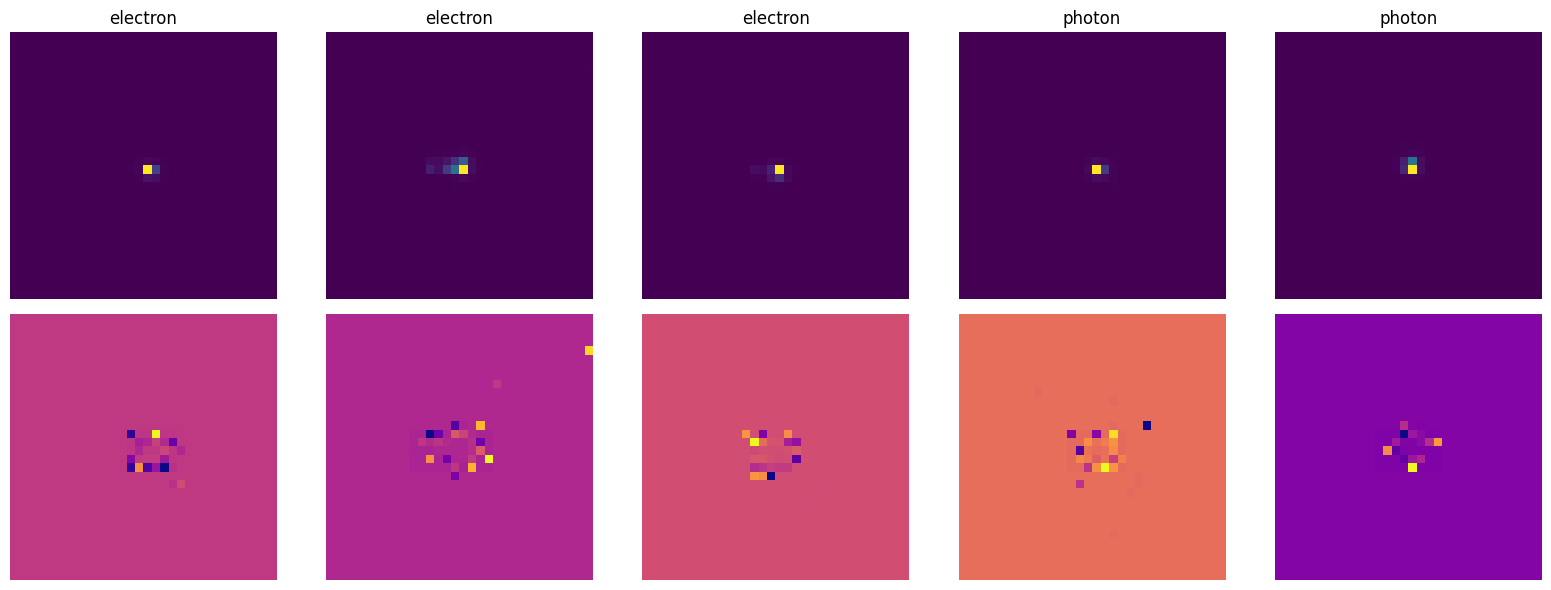

In [3]:
bin2lab = {0: 'electron', 1: 'photon'}
num_img = 5
idxs = np.random.randint(0, img_arrs.shape[0], size=(num_img,))
fig, axes = plt.subplots(2, num_img, figsize=(16, 6))
for i in range(num_img):
    ax0 = axes[0, i]
    ax0.imshow(img_arrs[idxs[i]][:, :, 0], cmap='viridis')
    ax0.axis('off')
    ax1 = axes[1, i]
    ax1.imshow(img_arrs[idxs[i]][:, :, 1], cmap='plasma')
    ax1.axis('off')
    ax0.set_title(bin2lab[labels[idxs[i]]])
plt.tight_layout()
plt.show()



**We adjust the shape of our image data from `(32, 32, 2)` to `(2, 32, 32)` to match PyTorch's input requirements. Then, we perform a stratified 80/20 split of the data to create training and testing sets.**


In [4]:
img_arrs = np.transpose(img_arrs, (0, 3, 1, 2))
print("After transpose:", img_arrs.shape)

train_idx, test_idx = train_test_split(np.arange(len(labels)), test_size=0.2, random_state=seed, stratify=labels)
print("Train samples:", len(train_idx), "Test samples:", len(test_idx))


After transpose: (498000, 2, 32, 32)
Train samples: 398400 Test samples: 99600


In [5]:
class ParticleDataset(Dataset):
    def __init__(self, images, labels, indices):
        self.images = images[indices]
        self.labels = labels[indices]
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        image = self.images[idx].astype(np.float32)  # convert to float32
        label = self.labels[idx]
        return torch.tensor(image), torch.tensor(label)
train_dataset = ParticleDataset(img_arrs, labels, train_idx)
test_dataset = ParticleDataset(img_arrs, labels, test_idx)


In [6]:
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)


**The ResNet-15 model that I implemented is inspired by the original ResNet paper with modifications for the 32×32 image dataset
Each block contains two 3×3 convolutions with batch normalization and ReLU activations. Skip connections add the block's input to its output. When dimensions differ, a 1×1 convolution (with batch normalization) is used in the skip path. Downsampling is performed in selected blocks by using a stride of 2 in the first convolution, reducing spatial dimensions. After the residual blocks, an adaptive average pooling layer (GAP) produces a fixed-length feature vector, which is then passed through a fully connected layer for binary classification.**


In [7]:
class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )
            
    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = self.relu(out)
        return out

class ResNet15(nn.Module):
    def __init__(self, block, num_blocks, num_classes=2):
        super(ResNet15, self).__init__()
        self.in_planes = 16
        
        self.conv1 = nn.Conv2d(2, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        
        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 64, num_blocks[2], stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(64 * block.expansion, num_classes)
        
    def _make_layer(self, block, planes, num_blocks, stride):
        layers = []
        layers.append(block(self.in_planes, planes, stride))
        self.in_planes = planes * block.expansion
        for _ in range(1, num_blocks):
            layers.append(block(self.in_planes, planes))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avgpool(out)
        out = torch.flatten(out, 1)
        out = self.fc(out)
        return out
model = ResNet15(BasicBlock, [2, 2, 2]).to(device)
print(model)


ResNet15(
  (conv1): Conv2d(2, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=

Epoch [1/20] Train Loss: 0.6126 Acc: 0.6675 | Test Loss: 0.5927 Acc: 0.7034 AUC: 0.7712
Epoch [2/20] Train Loss: 0.5673 Acc: 0.7142 | Test Loss: 0.5626 Acc: 0.7155 AUC: 0.7828
Epoch [3/20] Train Loss: 0.5577 Acc: 0.7205 | Test Loss: 0.5661 Acc: 0.7163 AUC: 0.7889
Epoch [4/20] Train Loss: 0.5530 Acc: 0.7242 | Test Loss: 0.5479 Acc: 0.7290 AUC: 0.7959
Epoch [5/20] Train Loss: 0.5492 Acc: 0.7268 | Test Loss: 0.5432 Acc: 0.7320 AUC: 0.8009
Epoch [6/20] Train Loss: 0.5459 Acc: 0.7291 | Test Loss: 0.5429 Acc: 0.7307 AUC: 0.8001
Epoch [7/20] Train Loss: 0.5434 Acc: 0.7309 | Test Loss: 0.5419 Acc: 0.7308 AUC: 0.8039
Epoch [8/20] Train Loss: 0.5414 Acc: 0.7324 | Test Loss: 0.5406 Acc: 0.7316 AUC: 0.8030
Epoch [9/20] Train Loss: 0.5394 Acc: 0.7336 | Test Loss: 0.5399 Acc: 0.7350 AUC: 0.8086
Epoch [10/20] Train Loss: 0.5378 Acc: 0.7348 | Test Loss: 0.5344 Acc: 0.7392 AUC: 0.8085
Epoch [11/20] Train Loss: 0.5359 Acc: 0.7356 | Test Loss: 0.5365 Acc: 0.7348 AUC: 0.8059
Epoch [12/20] Train Loss: 0.53

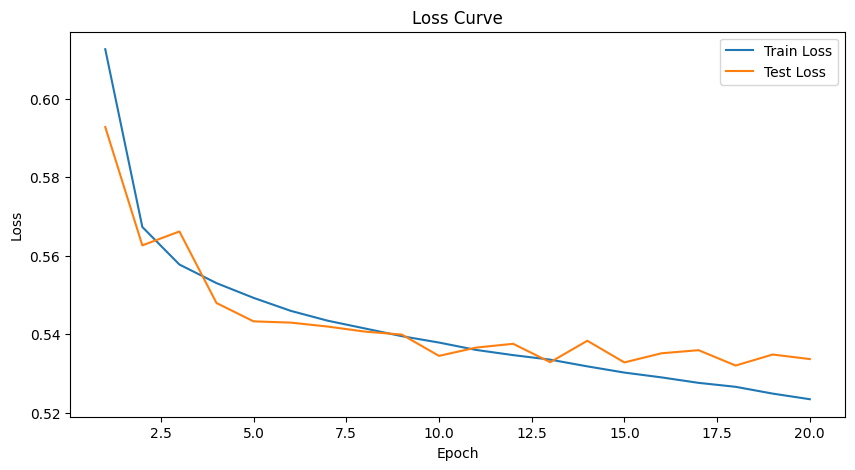

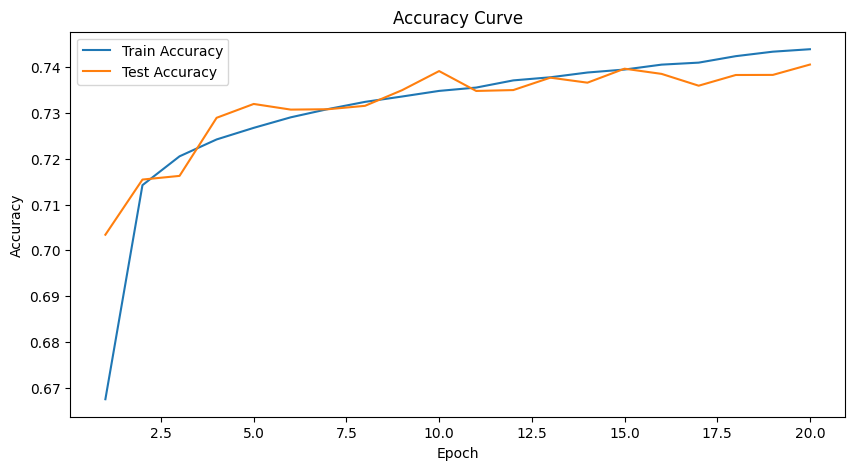

Final Test Accuracy: 0.7406
Final Test AUC: 0.8099


In [8]:
num_epochs = 20
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    all_preds = []
    all_labels = []
    
    for images, labels_batch in train_loader:
        images = images.to(device)
        labels_batch = labels_batch.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels_batch)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels_batch.cpu().numpy())
        
    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = accuracy_score(all_labels, all_preds)
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)



    
    model.eval()
    test_running_loss = 0.0
    all_test_preds = []
    all_test_labels = []
    all_test_probs = []
    with torch.no_grad():
        for images, labels_batch in test_loader:
            images = images.to(device)
            labels_batch = labels_batch.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels_batch)
            test_running_loss += loss.item() * images.size(0)
            preds = torch.argmax(outputs, dim=1)
            probs = nn.functional.softmax(outputs, dim=1)[:, 1]
            all_test_preds.extend(preds.cpu().numpy())
            all_test_labels.extend(labels_batch.cpu().numpy())
            all_test_probs.extend(probs.cpu().numpy())
            
    test_loss = test_running_loss / len(test_dataset)
    test_acc = accuracy_score(all_test_labels, all_test_preds)
    test_auc = roc_auc_score(all_test_labels, all_test_probs)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)
    
    print(f"Epoch [{epoch+1}/{num_epochs}] Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} | Test Loss: {test_loss:.4f} Acc: {test_acc:.4f} AUC: {test_auc:.4f}")




plt.figure(figsize=(10,5))
plt.plot(range(1, num_epochs+1), train_losses, label="Train Loss")
plt.plot(range(1, num_epochs+1), test_losses, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()
plt.show()


plt.figure(figsize=(10,5))
plt.plot(range(1, num_epochs+1), train_accuracies, label="Train Accuracy")
plt.plot(range(1, num_epochs+1), test_accuracies, label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy Curve")
plt.legend()
plt.show()





model.eval()
all_test_preds = []
all_test_labels = []
all_test_probs = []
with torch.no_grad():
    for images, labels_batch in test_loader:
        images = images.to(device)
        labels_batch = labels_batch.to(device)
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)
        probs = nn.functional.softmax(outputs, dim=1)[:, 1]
        all_test_preds.extend(preds.cpu().numpy())
        all_test_labels.extend(labels_batch.cpu().numpy())
        all_test_probs.extend(probs.cpu().numpy())
        
final_acc = accuracy_score(all_test_labels, all_test_preds)
final_auc = roc_auc_score(all_test_labels, all_test_probs)
print("Final Test Accuracy: {:.4f}".format(final_acc))
print("Final Test AUC: {:.4f}".format(final_auc))

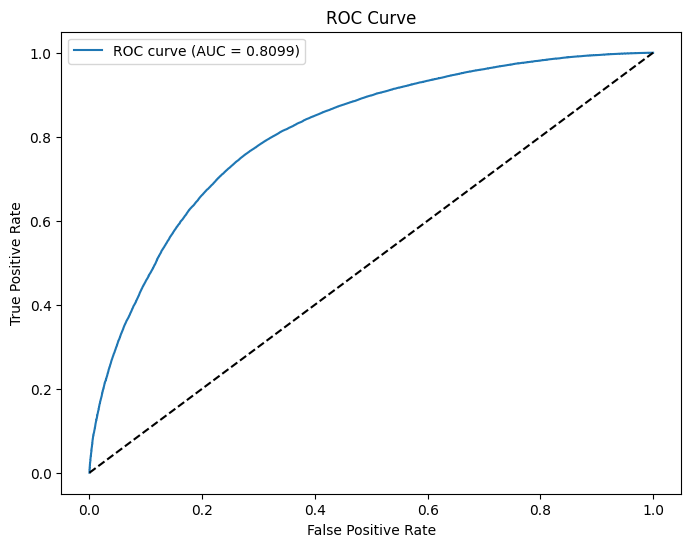

In [9]:
fpr, tpr, thresholds = roc_curve(all_test_labels, all_test_probs)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {final_auc:.4f})")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


In [10]:
torch.save(model.state_dict(), "resnet15_particle_classifier.pth")
print("Model weights saved as resnet15_particle_classifier.pth")


Model weights saved as resnet15_particle_classifier.pth
